### 1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
df_california = fetch_california_housing(as_frame=True).frame
print(df_california.shape)
df_california.head(10)

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


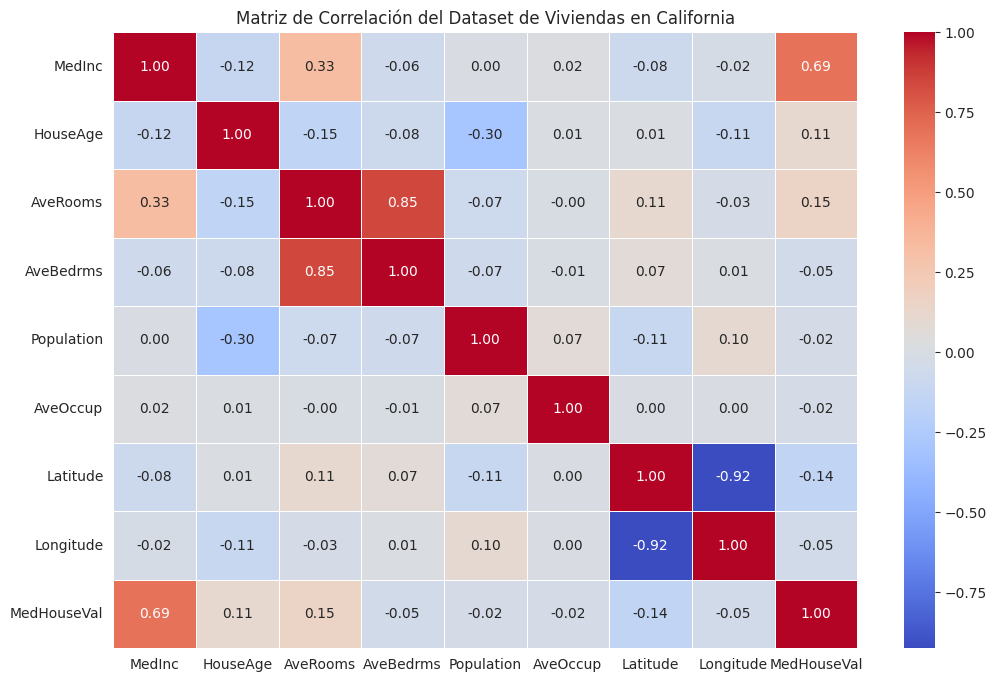

In [4]:
correlation_matrix = df_california.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación del Dataset de Viviendas en California")
plt.show()

#### 1. MedHouseVal
El atributo que tiene mayor correlación con el target es *MedInc*. Esto indica que a medida que aumenta el ingreso medio, tienden a aumentar las casas en ese bloque. El resto de los atributos, no posee una relación fuerte con el target.

#### 2. Otros atributos



*   *AveBedrms* y *AveRooms* tienen una alta correlación entre sí, esto nos dice que a medida que un bloque de casas tiene mas habitaciones, también tiene más dormitorios.
*   *Latitude* y *Longitude* poseen una alta correlación negativa.

En este sentido para eliminar la correlación entre las features podríamos eliminar 1 de cada par que tiene alta correlación entre sí (es decir, podría ser redundante para nuestro modelo).

Lo que sí es de vital importancia hay que notar es que al eliminar un feature del dataset, se debe recalcular la matriz de correlación de los datos (introduciendo quizá en consideración para eliminación ciertas features que en principio no estaban tan correlacionadas)


### 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

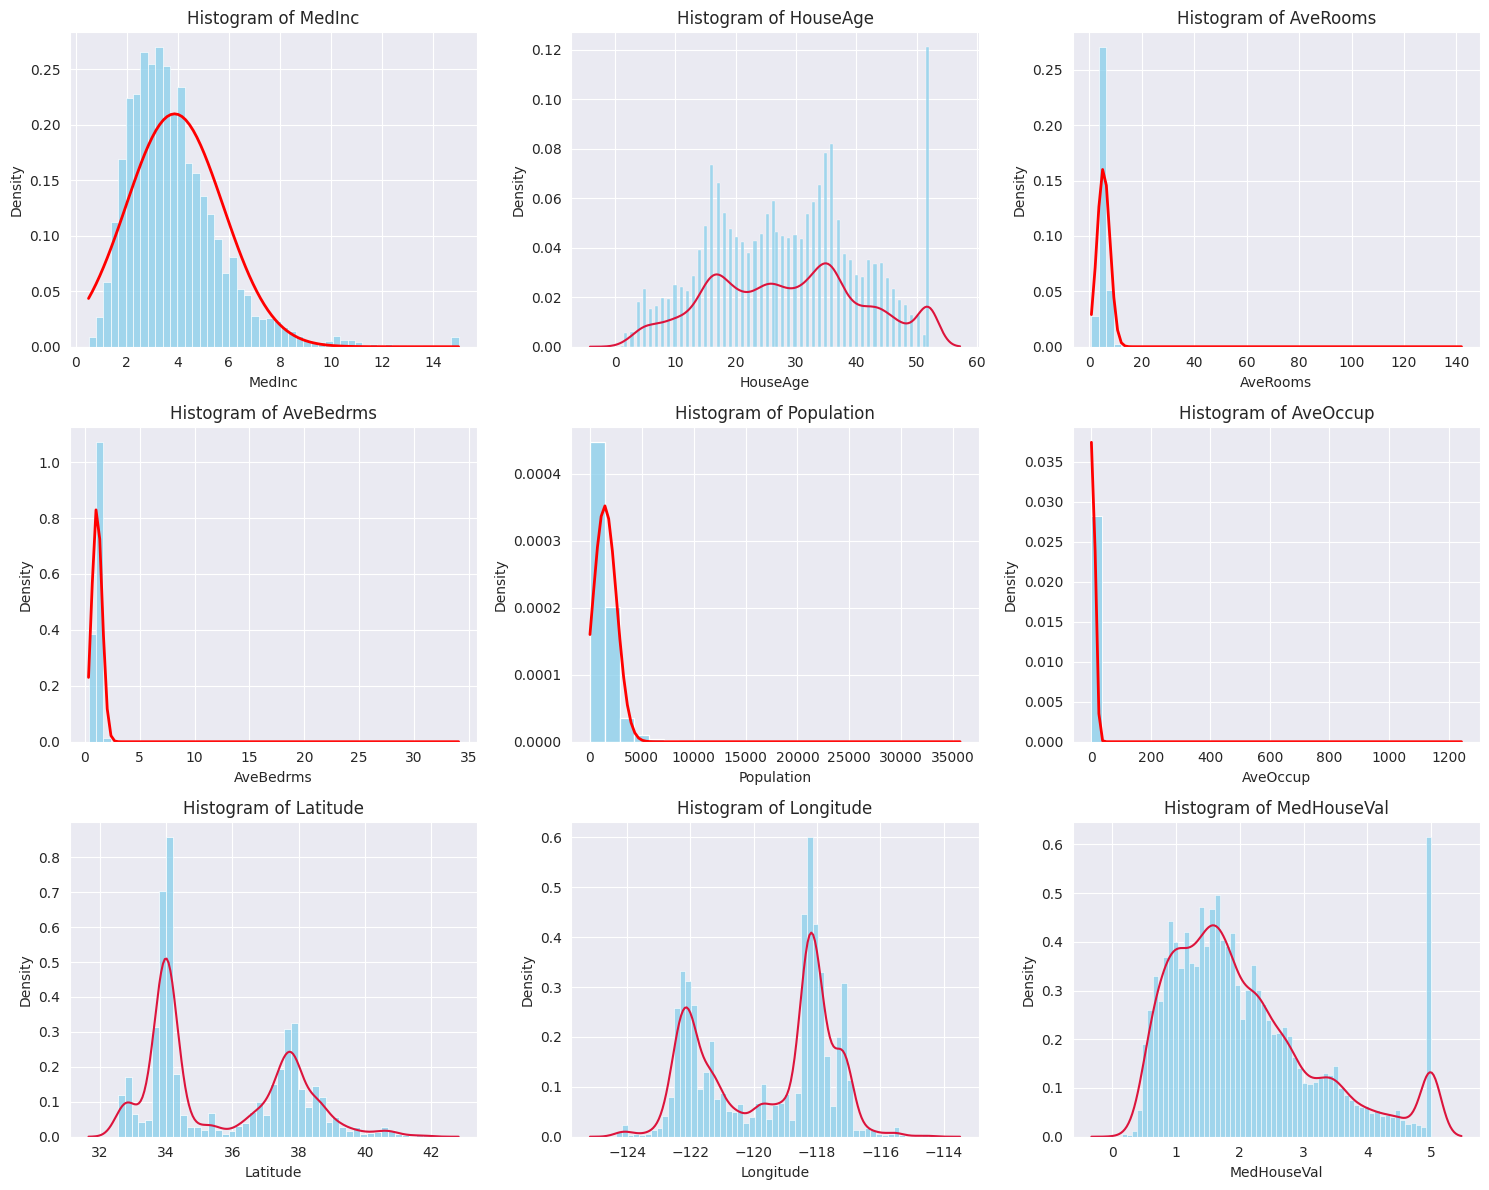

In [9]:
import numpy as np
from scipy.stats import norm
def plot_histogram(df):
    columns_to_plot = df.columns 
    bins_list = [50, 100, 50, 50, 25, 35, 45, 55, 60]  # Customize bins for each plot
    kde_columns = ['HouseAge', 'Latitude' , 'Longitude', 'MedHouseVal'] # these must be estimated by kde
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten() 
    for i, col in enumerate(columns_to_plot):
        sns.histplot(df[col], stat='density', bins=bins_list[i], kde=False, ax=axes[i], color='skyblue')
        
        if col in kde_columns:
            sns.kdeplot(df[col], ax=axes[i], color='crimson')
        else:
            mean = df[col].mean()
            std = df[col].std()
            
            x = np.linspace(df[col].min(), df[col].max(), 100)
            y = norm.pdf(x, mean, std)
            axes[i].plot(x, y, color='red', lw=2)
        
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
plot_histogram(df_california)

A partir de los gráficos podemos concluir:

- En `MedInc, HouseAge, Latitude y Longitude`: La mayoría se podría interpretar como suma de distribuciones gaussianas con distintas medias y desvíos standard.

- Vemos que hay algunos gráficos que tienen un pico pronunciado:
    - En el caso de `MedHouseVal` (que es el target) podemos ver que hay mucha densidad acumulada cerca del 5, esto puede deberse a un valor de saturación en el dataset, es decir que si excede los 500.000 por ejemplo en el caso de que la mediana en el bloque de 650.000, se computa como 500.000.
    - Vemos que en `AveRooms,AveBedrms,Population y AveOccup` tenemos la presencia de outliers, con lo cual no podemos ver en el histograma la verdadera forma de la distribución. Puede haber datos que han sido mal introducidos ya sea por error de tipeo o del sistema, o porque naturalmente existe ese dato.

A modo ilustrativo de cómo se debería limpiar el dataset, se procede a filtrar outliers y valores de saturación:


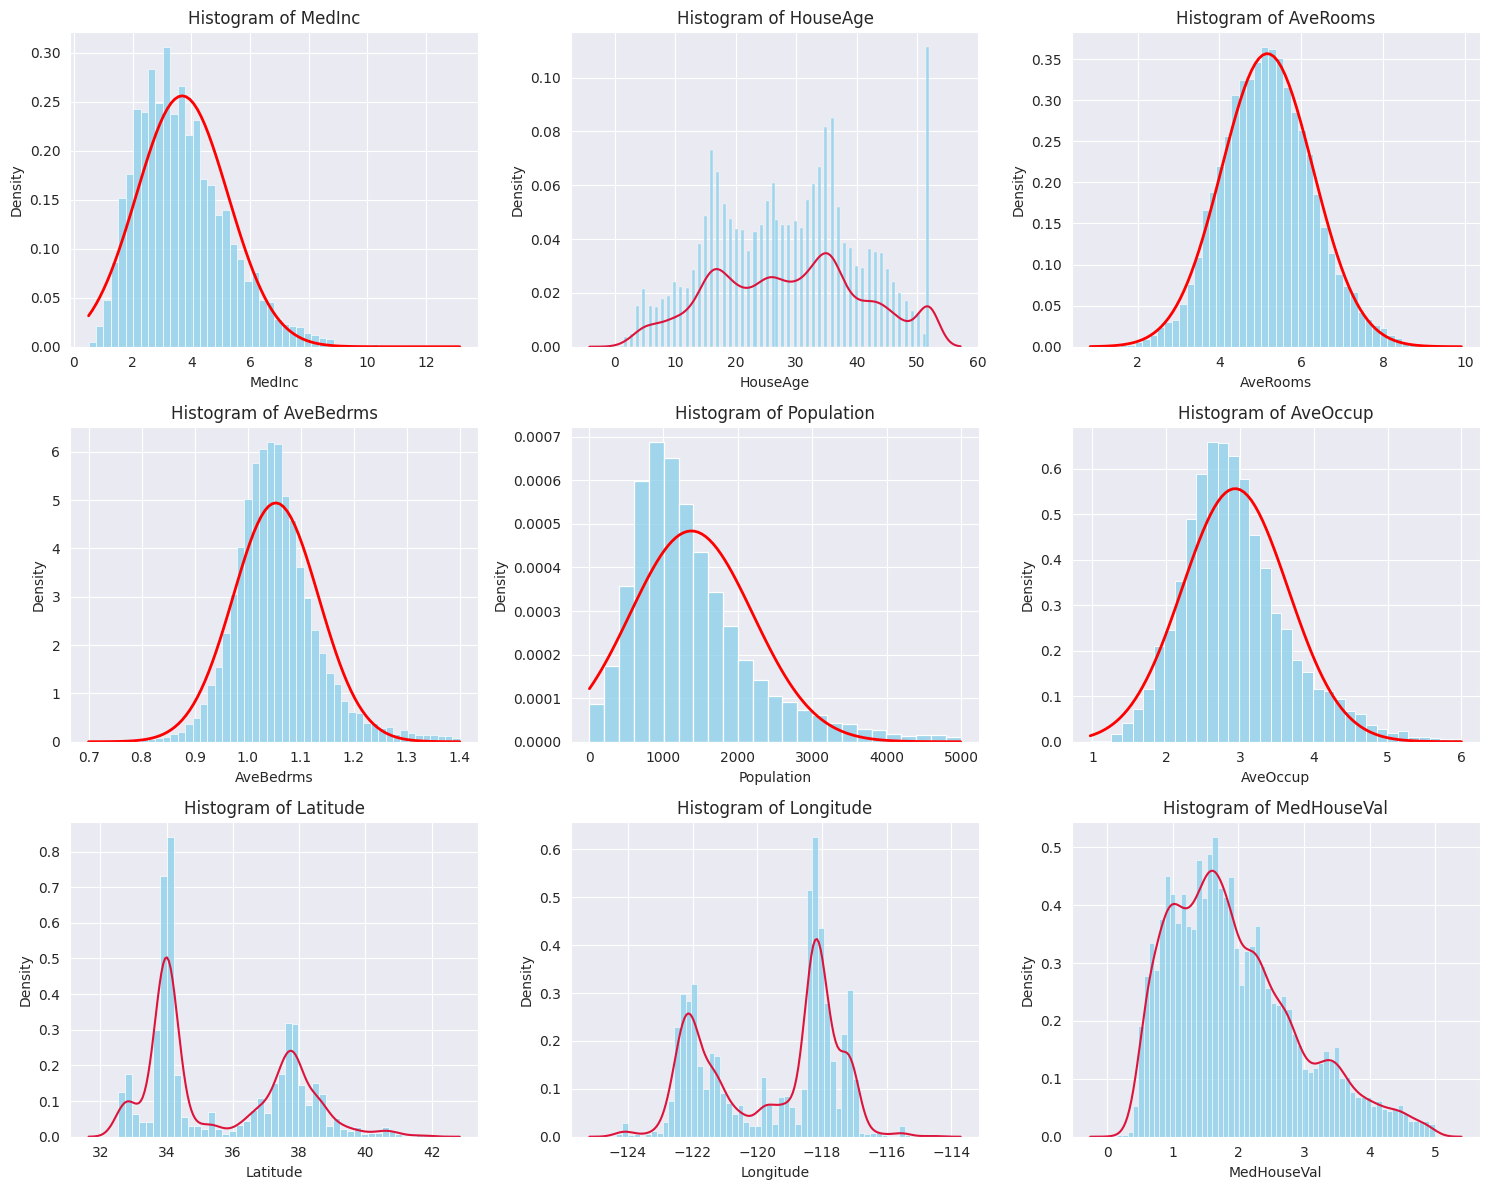

In [10]:
def filter_outliers(df_to_filter):    
    new_df = df_to_filter.copy()
    new_df = new_df[(0 <= new_df["MedInc"]) & (new_df["MedInc"] <= 14)] 
    new_df = new_df[(0 <= new_df["AveRooms"]) & (new_df["AveRooms"] <= 10)] 
    new_df = new_df[(0.7 <= new_df["AveBedrms"]) & (new_df["AveBedrms"] <= 1.4)]
    new_df = new_df[(0 <= new_df["Population"]) & (new_df["Population"] <= 5000)]
    new_df = new_df[(0 <= new_df["AveOccup"]) & (new_df["AveOccup"] <= 6)]
    new_df = new_df[(0 <= new_df["MedHouseVal"]) & (new_df["MedHouseVal"] <= 4.99999999)]
    return new_df

california_data_wo_outliers = filter_outliers(df_california)
plot_histogram(filter_outliers(df_california))

Aquí se nota con mayor claridad la verdadera distribución de los datos que tenían outliers (que se trata de una gaussina con una sola media y varianza)